# Задание 2. Интерполяция кривой

Сгенерируйте от 5 до 20 точек со случайными разными координатами (x, y), расположите их на координатной плоскости

1. С помощью библиотеки scipy примените один из её [алгоритмов интерполяции](https://docs.scipy.org/doc/scipy/reference/interpolate.html) к сгенерированным данным
2. Изучите математический подход метод выбранного алгоритма интерполяции в scipy. Найдите и продемонстрируйте при сдаче реализацию метода в исходном коде библиотеки scipy. Найти можно в [github репозитории проекта](https://github.com/scipy/scipy)
3. Выберите среди методов интерполяции в scipy любой другой метод интерполяции (кроме линейной интерполяций). Реализуйте выбранный метод без использования сторонних библиотек. Разрешается использовать numpy для упрощения математичеких вычислений
4. Визуализируйте кривую интерполяции библиотечного и вашего алгоритмов с помощью  matplotlib. Сравните качество интерполяции своего и библиотечного методов, объясните разницу в качестве

# Решение

In [7]:
import numpy as np

SEED = 42  # for generating random values
points = np.random.random(size=(15, 2)) * 100
xs = points[:, 0]
ys = points[:, 1]
space = np.linspace(min(xs), max(xs), num=500)

## Алгоритмы интерполяции scipy.interpolate

Применим `scipy.interpolate.interp1d` c опцией `kind='linear'`, то есть линейную интерполяцию.

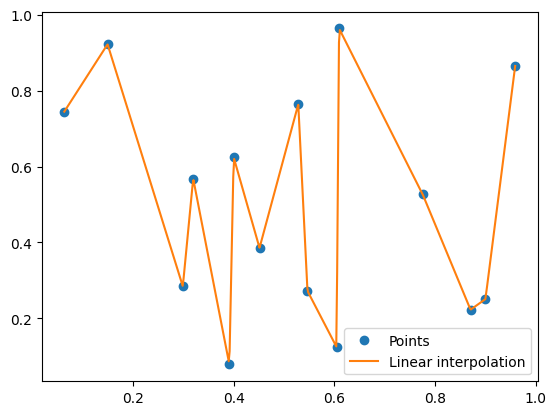

In [2]:
import matplotlib.pyplot as plt
from scipy import interpolate

plt.plot(xs, ys, "o", label="Points")
plt.plot(space, interpolate.interp1d(xs, ys, kind='linear')(space), label="Linear interpolation")
plt.legend();

## Библиотечная реализация

С точки зрения математики метод линейной интерполяции заключается в следующем: интерполирующая функция является кусочно-линейной и $\forall x \in (x_0, x_1)$ интерполирующая функция $f(x) = y_0 + \dfrac{y_1 - y_0}{x_1 - x_0} \cdot (x - x_0)$.

Крайне упрощенно код, реализующий линейную интерполяцию в библиотеке `scipy` выглядит так (на самом деле там очень много оберток, так что я постарался по максимуму всё упростить, но тело `__call__` практически полностью скопировано с GitHub библиотеки):

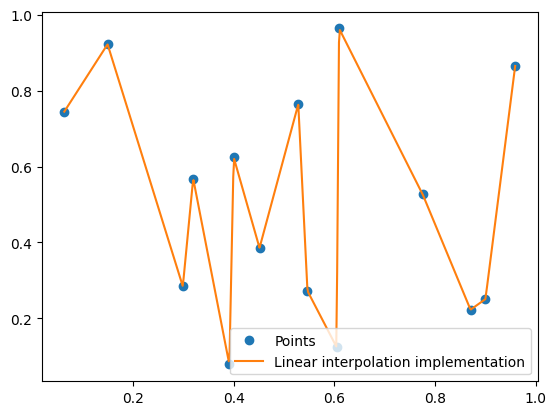

In [3]:
from numpy import (array, searchsorted, asarray)


class LinearInterpolatorImpl:
    def __init__(self, x, y):
        x = array(x)
        y = array(y)

        i = np.argsort(x, kind="mergesort")
        x = x[i]
        y = np.take(y, i, axis=-1)

        self.y = y
        self._y = self.y.reshape((self.y.shape[0], -1))
        self.x = x

    def __call__(self, x):
        x = asarray(x)
        x_indices = searchsorted(self.x, x)

        lo = x_indices - 1
        hi = x_indices

        x_lo = self.x[lo]
        x_hi = self.x[hi]
        y_lo = self._y[lo]
        y_hi = self._y[hi]

        slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]

        f = slope * (x - x_lo)[:, None] + y_lo

        return f.reshape(x.shape)


plt.plot(xs, ys, "o", label="Points")
plt.plot(space, LinearInterpolatorImpl(xs, ys)(space), label="Linear interpolation implementation")
plt.legend();

## Собственная реализация интерполяции

Реализуем алгоритм интерполяции Лагранжа. В данном случае для интерполяции используется следующий многочлен:
$$L(x) = \sum_{i=0}^n y_i \cdot \prod_{j = 0, j \neq i}^n \dfrac{x - x_j}{x_i - x_j}$$
По определению:

In [4]:
class LagrangeInterpolation:
    def __init__(self, x, y):
        x = array(x)
        y = array(y)

        i = np.argsort(x, kind="mergesort")
        self.x = x[i]
        self.y = np.take(y, i, axis=-1)

    def __call__(self, x):
        return np.asarray(
            [np.sum(
                self.y * np.asarray([
                    np.prod([
                        (x[k] - self.x[j]) / (self.x[i] - self.x[j])
                        for j in range(len(self.x)) if j != i
                    ])
                    for i in range(len(self.x))
                ])) for k in range(len(x))]
        )

## Сравнение собственной и библиотечной реализаций

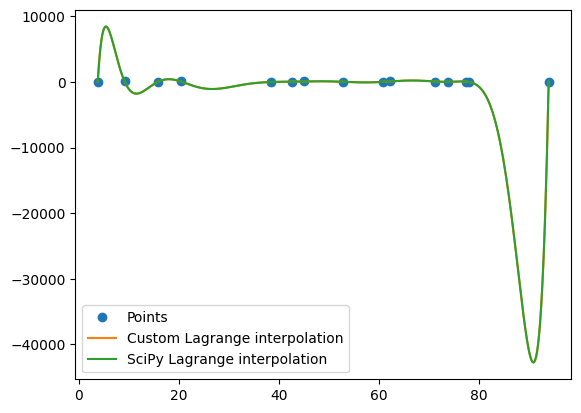

In [8]:
plt.plot(xs, ys, 'o', label="Points")
plt.plot(space, LagrangeInterpolation(xs, ys)(space), label="Custom Lagrange interpolation")
plt.plot(space, interpolate.lagrange(xs, ys)(space), label="SciPy Lagrange interpolation")
plt.legend();

__Вывод__: Разницы нет, видимо, в силу простоты алгоритма интерполяции Лагранжа - формула не зависит от способа разбиения `space` на отрезки с собственной интерполирующей формулой.